### Exploratory Analysis to Find Failed Logins

For this notebook, we are looking for excessive login attempts by individual users.

This guides our later creation of comparison analytics for a production setting.

__Damian Herrick__  
__SAS Institute__  
__[damian.herrick@sas.com](mailto:damian.herrick@sas.com)__  

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import swat
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
os.environ["CAS_CLIENT_SSL_CA_LIST"]="/home/ds/cascert.pem"

conn = swat.CAS("<your-CAS-server-url>", 5570)

Set current CASLIB to the Windows Host Events library we created earlier, and load our data.

In [3]:
conn.setsessopt('WH')

out = conn.loadtable('wls_day_02_hr13.sashdat', caslib='WH')

NOTE: Cloud Analytic Services made the file wls_day_02_hr13.sashdat available as table WLS_DAY_02_HR13 in caslib CASUSER(daherr).


We know from Windows documentation that a logged event with ID `4625` is a failed login - so we begin by trimming our dataset to have only failed logins.

In [5]:
clause = "EventID = 4625"
where = clause.format(table="", not_missing="Is Not Missing")

conn.partition(table={"name": "wls_day_02_hr13", "where":where}, 
               casout={"name": "WLS_DAY02_HR13_FAILED"})

ERROR: The table WLS_DAY02_HR13_FAILED already exists in the session.
ERROR: The action stopped due to errors.


+ Elapsed: 0.00285s, user: 0.00279s, mem: 1.23mb

To get our dataset grouped by users and their counts, we'll use the `fedsql` actionset and create a table with a SQL query.

In [6]:
conn.loadactionset("fedsql")

NOTE: Added action set 'fedsql'.


[actionset]

 'fedsql'

+ Elapsed: 0.0032s, user: 0.00162s, sys: 0.00152s, mem: 0.23mb

In [7]:
query = f"CREATE TABLE WLS_DAY02_HR13_FAILED_USERS AS SELECT UserName, count(UserName) as Failures \
          FROM WLS_DAY02_HR13_FAILED GROUP BY UserName"

conn.fedsql.execdirect(query)

NOTE: Table WLS_DAY02_HR13_FAILED_USERS was created in caslib CASUSER(daherr) with 142 rows returned.


+ Elapsed: 0.824s, user: 1.03s, sys: 2.17s, mem: 384mb

Now we'll create a local `CASTable` object and use that to examine what the failed users count looks like.

Basically - this is a sanity check for our potential analytic. We're checking to see if there are some users who are failing a lot more than others.

In [8]:
failedUsers = conn.CASTable('WLS_DAY02_HR13_FAILED_USERS').sort('Failures', ascending=False)

In [9]:
failedUsers.head(10)

,UserName,FAILURES
0,Comp065845$,636
1,Administrator,207
2,AppService,163
3,User031784,79
4,User006226,36
5,Scanner,33
6,User759472,19
7,User986685,18
8,User718489,17
9,User096590,15


Based on the top ten failures, we can see that a few accounts fail a LOT more than the rest. Even more interesting, one of the failures is the `Administrator` account. That's an account we hope would not fail that often.

Last thing we'll do here is just get a sense of the range of our data.

* How many users are there? (the N)
* What is the range of the failure counts? (1 - 636)
* etc....

In [11]:
failedUsers.FAILURES.summary()['Summary'].transpose()

,0
Column,FAILURES
Min,1
Max,636
N,142
NMiss,0
Mean,10.6127
Sum,1507
Std,57.6967
StdErr,4.8418
Var,3328.91


And, lastly, let's plot this so we have a better visual sense of how this works.

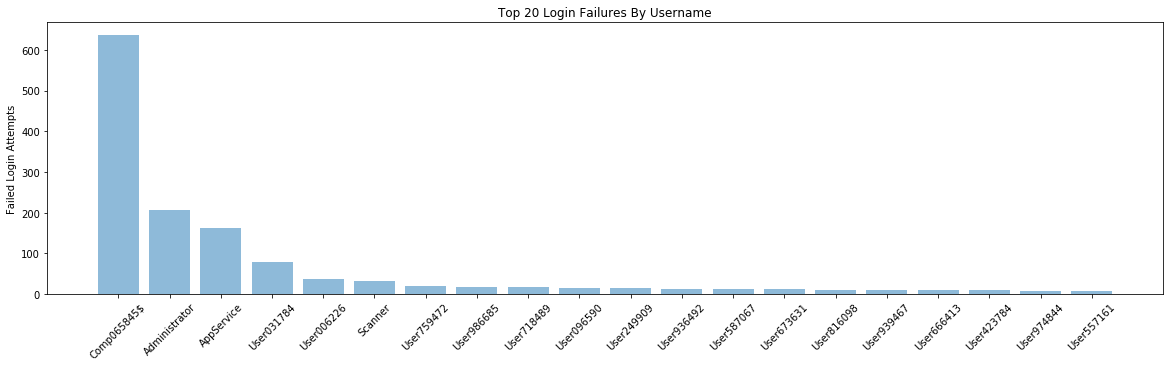

In [12]:
y_pos = np.arange(20)

plt.figure(figsize=(20,5))
plt.bar(y_pos, failedUsers.FAILURES.values[:20], align='center', alpha=0.5)
plt.xticks(y_pos, failedUsers.UserName.values[:20], rotation=45)
plt.ylabel('Failed Login Attempts')
plt.title('Top 20 Login Failures By Username')
plt.savefig('loginFailures.png', bbox_inches='tight')

plt.show()

In [13]:
conn.close()